# **Import Libraries and unzip files**

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
#Data Fetching
!pip install opencv-contrib-python
from IPython.display import clear_output
!unzip "/content/drive/MyDrive/INVERSE_WORDS_FINAL2-20230211T185906Z-001.zip" -d "/content/"
!unzip "/content/drive/MyDrive/words_text-20230211T163818Z-001.zip" -d "/content/"
clear_output()

In [3]:
!pip install PyArabic

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 126.4/126.4 KB 10.8 MB/s eta 0:00:00


In [4]:
pip install jiwer

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.4/1.4 MB 53.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 36.7 MB/s eta 0:00:00


In [5]:
#Useful imports
#will remain the same
from tensorflow.keras.layers.experimental.preprocessing import StringLookup
from tensorflow import keras

import pyarabic.araby as araby
import matplotlib.pyplot as plt
import tensorflow as tf
import numpy as np
import os
import cv2 as cv
from jiwer import cer, wer

np.random.seed(42)
tf.random.set_seed(42)

# **Organize and split files**

In [6]:
filenames_img=sorted(os.listdir('/content/INVERSE_WORDS_FINAL2'))
filenames_gt=sorted(os.listdir('/content/words_text'))
filenames_imgsplit=[filename.replace('.jpg', '') for filename in filenames_img]
filenames_gtsplit=[filename.replace('.txt', '') for filename in filenames_gt]
print(len(filenames_imgsplit))
print(len(filenames_gtsplit))

11042
11042


In [7]:
split_idx = int(0.8 * len(filenames_img))
train_samples = filenames_img[:split_idx]
train_samples_split = filenames_imgsplit[:split_idx]
val_test_samples = filenames_img[split_idx:]
val_test_samples_split = filenames_imgsplit[split_idx:]

val_split_idx = int(0.5 * len(val_test_samples))
validation_samples = val_test_samples[:val_split_idx]
validation_samples_split = val_test_samples_split[:val_split_idx]
test_samples = val_test_samples[val_split_idx:]
test_samples_split = val_test_samples_split[val_split_idx:]

assert len(filenames_imgsplit) == len(train_samples) + len(validation_samples) + len(
    test_samples
)

print(f"Total training samples: {len(train_samples)}")
print(f"Total validation samples: {len(validation_samples)}")
print(f"Total test samples: {len(test_samples)}")
print(f' Example from training dataset {train_samples_split[0]}')

Total training samples: 8833
Total validation samples: 1104
Total test samples: 1105
 Example from training dataset img0


In [8]:
#get data and labels as lists
base_path='/content/'
base_image_path = os.path.join(base_path, "/content/INVERSE_WORDS_FINAL2")
base_GT_path = os.path.join(base_path, "/content/words_text")

def get_image_paths_and_labels(filenames_img, filenames_imgsplit):
    paths = []
    labels = []
    for i in range(len(filenames_imgsplit)):
        img_path = os.path.join(
            base_image_path,  filenames_img[i]
        )
        if os.path.getsize(img_path):
            paths.append(img_path)
            label_path = os.path.join(
            base_GT_path,  filenames_imgsplit[i]+'.txt'
        )
        label_file = open(label_path, "r") 
        labels.append(label_file.read())

    return paths, labels

train_img_paths, train_labels = get_image_paths_and_labels(train_samples, train_samples_split)
validation_img_paths, validation_labels = get_image_paths_and_labels(validation_samples, validation_samples_split)
test_img_paths, test_labels = get_image_paths_and_labels(test_samples, test_samples_split)

In [9]:
# Find maximum length and the size of the vocabulary in the training data.
train_labels_cleaned = []
characters = set()
max_len = 0
for label in train_labels:
    label = label.split(" ")[-1].strip()
    label = araby.strip_diacritics(label)
    for char in label:
        characters.add(char)

    max_len = max(max_len, len(label))
    train_labels_cleaned.append(label)

print("Maximum length: ", max_len)
print("Vocab size: ", len(characters))

# Check some label samples.
train_labels_cleaned[:10]

Maximum length:  10
Vocab size:  49


['المؤ', 'لف', 'ينفي', 'لا', 'جيرا', 'بحربة', 'فأخذها', 'رسول', 'الله', 'منه']

In [10]:
def clean_labels(labels):
    cleaned_labels = []
    for label in labels:
        label = label.split(" ")[-1].strip()
        label = araby.strip_diacritics(label)
        cleaned_labels.append(label)
    return cleaned_labels


validation_labels_cleaned = clean_labels(validation_labels)
test_labels_cleaned = clean_labels(test_labels)

     

In [11]:
validation_labels_cleaned

['هذه',
 'أردت',
 'أن',
 'تفضحنا',
 'إن',
 'معي',
 'أصحابي',
 'على',
 'مثل',
 'رأيي',
 'تبيعهم',
 'العلامة',
 'وتحسن',
 'ونجعل',
 'عندك',
 'رهنا',
 'من',
 'ما',
 'فيه',
 'وفاء',
 'وأراد',
 'أبو',
 'من',
 'نائلة',
 'بذكر',
 'الحلقة',
 'وهي',
 'السلاح',
 'أن',
 'لا',
 'ينكر',
 'السلاح',
 'إذا',
 'بين',
 'جاء',
 'مع',
 'أصحابه',
 'فقال',
 'إن',
 'في',
 'الحلقة',
 'لوفاء',
 'أبو',
 'نائلة',
 'كل',
 'إلى',
 'أصحابه',
 'فأخذوا',
 'السلاح',
 'وساروا',
 'إليه',
 'وشيعهم',
 'النبي',
 'إلى',
 'بقيع',
 'علامة',
 'الغر',
 'قد',
 'ودعا',
 'لهم',
 'فلما',
 'انتهوا',
 'ا',
 'إلى',
 'حصن',
 'كعب،',
 'وبعد',
 'هتف',
 'به',
 'أبو',
 'نائلة',
 'وكان',
 'كعب',
 'قريب',
 'عهد',
 'فوثب',
 'إليه',
 'فكل',
 'وتحدثوا',
 'ا',
 'ساعة',
 'وسار',
 'معهم',
 'إلى',
 'شعب',
 'ثم',
 'إن',
 'أبا',
 'أعحوبة',
 'تائلة',
 'أخذ',
 'بر',
 'أس',
 'كعب،',
 'وشم',
 'بيده',
 'وقال',
 'ما',
 'رأيت',
 'بالجواب',
 'يأتي',
 'كالليلة',
 'طيبا',
 'قط',
 'ثم',
 'مشى',
 'ساعة',
 'وعاد',
 'لمثلها',
 'حتى',
 'اطمأن',
 'بها',
 'كعب',
 'ثم

In [12]:
print(characters)

{'ة', '\u200e', 'إ', 'ق', '٣', '{', 'ح', 'غ', '.', 'خ', 'ى', 'ث', ')', 'أ', '،', 'ت', 'ر', '؛', '؟', 'ظ', '(', 'ؤ', 'ب', 'ذ', 'ف', 'ء', 'ن', '«', 'ك', 'س', 'ل', 'ع', 'ا', 'د', 'ض', ']', 'ه', 'ئ', 'ي', '!', 'ط', '[', 'ص', 'آ', 'ش', 'م', 'و', 'ج', 'ز'}


In [13]:
len(characters)

49

# **Pre-Training**

In [14]:
AUTOTUNE = tf.data.AUTOTUNE

# Mapping characters to integers.
char_to_num = StringLookup(vocabulary=list(characters), mask_token=None)

# Mapping integers back to original characters.
num_to_char = StringLookup(
    vocabulary=char_to_num.get_vocabulary(), mask_token=None, invert=True
)

In [15]:
def distortion_free_resize(image, img_size):
    w, h = img_size
    image = tf.image.resize(image, size=(h, w), preserve_aspect_ratio=True)

    # Check tha amount of padding needed to be done.
    pad_height = h - tf.shape(image)[0]
    pad_width = w - tf.shape(image)[1]

    # Only necessary if you want to do same amount of padding on both sides.
    if pad_height % 2 != 0:
        height = pad_height // 2
        pad_height_top = height + 1
        pad_height_bottom = height
    else:
        pad_height_top = pad_height_bottom = pad_height // 2

    if pad_width % 2 != 0:
        width = pad_width // 2
        pad_width_left = width + 1
        pad_width_right = width
    else:
        pad_width_left = pad_width_right = pad_width // 2

    image = tf.pad(
        image,
        paddings=[
            [pad_height_top, pad_height_bottom],
            [pad_width_left, pad_width_right],
            [0, 0],
        ],
        constant_values=255,
    )

    image = tf.transpose(image, perm=[1, 0, 2])
    image = tf.image.flip_left_right(image)
    return image


In [16]:
print(train_labels_cleaned)

['المؤ', 'لف', 'ينفي', 'لا', 'جيرا', 'بحربة', 'فأخذها', 'رسول', 'الله', 'منه', 'وقتله', 'بها', 'وقيل', 'بل', 'كانت', 'انا', 'حربة', 'الزبير', 'أخذها', 'منه', 'وقيل', 'أخذها', 'من', 'الحارث', 'بن', 'الصمة', 'وقد', 'وأما', 'عبد', 'الله', 'بن', 'حميد،', 'فقتله', 'أبو', 'دجانة', 'الأنصاري', 'ولما', 'كانت', 'جرح', 'رسول', 'الله', 'جعل', 'الدم', 'يسيل', 'على', 'وجهه', 'وهو', 'يمسحه', 'الأنصار', 'ويقول', '))', 'كيف', 'يفلح', 'قوم', 'خضبوا', 'وجه', 'نبيهم', 'بالدم', 'وهو', 'مقدمة', 'يدعوهم', 'إلى', '))', 'وقاتل', 'دونه', 'نفر', 'خمسة', 'من', 'الأنصار', 'فقتلوا', 'الجوار', 'وتر', 'س', 'أبو', 'دجانة', 'رسول', 'الله', 'بنفسه', 'فكان', 'يقع', 'النبل', 'كة', 'في', 'ظهر', 'وهو', 'منحن', 'عليه', 'ورمى', 'سعد', 'بن', 'أبي', 'وقاص', 'في', 'دون', 'رسول', 'الله', 'فكان', 'رسول', 'الله', 'يناوله', 'السهم', 'ويقول', '((ار', 'الدار', 'م', 'فداك', 'أبي', 'وأصيب', 'يومئذ', 'عين', 'قتادة', 'بن', 'النعمان', 'دها', 'يعر', 'حسدتهم', 'رسول', 'الله', 'بيده', 'فكانت', 'أحسن', 'وقاتل', 'مصعب', 'بن', 'عمير', 'ومعه', '

In [17]:
batch_size = 64
padding_token = 99
image_width = 64
image_height = 32


def preprocess_image(image_path, img_size=(image_width, image_height)):
    image = tf.io.read_file(image_path)
    image = tf.image.decode_jpeg(image, 0)
    image = distortion_free_resize(image, img_size)
    image = tf.cast(image, tf.float32) / 255.0
    return image


def vectorize_label(label):
    print(label)
    label = char_to_num(tf.strings.unicode_split(label, input_encoding="UTF-8"))
    length = tf.shape(label)[0]
    pad_amount = max_len - length
    label = tf.pad(label, paddings=[[0, pad_amount]], constant_values=padding_token)
    return label
    
label=vectorize_label(train_labels_cleaned[2])
print(label)
indices = tf.gather(label, tf.where(tf.math.not_equal(label, padding_token)))
label = tf.strings.reduce_join(num_to_char(indices))
label = label.numpy().decode("utf-8")
print(label)

def process_images_labels(image_path, label):
    image = preprocess_image(image_path)
    label = vectorize_label(label)
    return {"image": image, "label": label}


def prepare_dataset(image_paths, labels):
    dataset = tf.data.Dataset.from_tensor_slices((image_paths, labels)).map(
        process_images_labels, num_parallel_calls=AUTOTUNE
    )
    return dataset.batch(batch_size).cache().prefetch(AUTOTUNE)

ينفي
tf.Tensor([39 27 25 39 99 99 99 99 99 99], shape=(10,), dtype=int64)
ينفي


In [18]:
train_ds = prepare_dataset(train_img_paths, train_labels_cleaned)
validation_ds = prepare_dataset(validation_img_paths, validation_labels_cleaned)
test_ds = prepare_dataset(test_img_paths, test_labels_cleaned)
     

Tensor("args_1:0", shape=(), dtype=string)
Tensor("args_1:0", shape=(), dtype=string)
Tensor("args_1:0", shape=(), dtype=string)


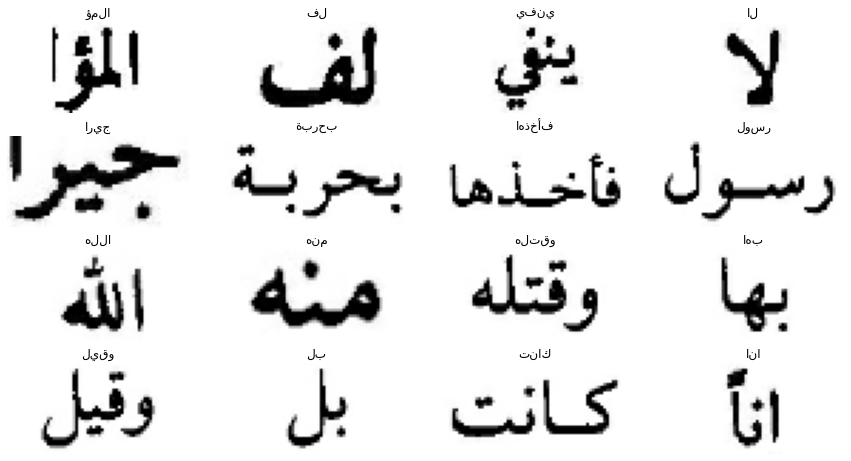

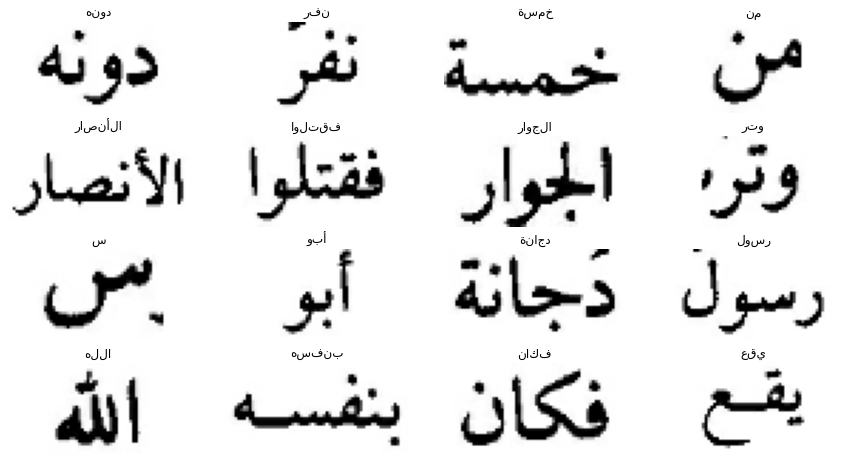

In [19]:
for data in train_ds.take(2):
    images, labels = data["image"], data["label"]

    _, ax = plt.subplots(4, 4, figsize=(15, 8))

    for i in range(16):
        img = images[i]
        img = tf.image.flip_left_right(img)
        img = tf.transpose(img, perm=[1, 0, 2])
        img = (img * 255.0).numpy().clip(0, 255).astype(np.uint8)
        img = img[:, :, 0]

        # Gather indices where label!= padding_token.
        label = labels[i]
        indices = tf.gather(label, tf.where(tf.math.not_equal(label, padding_token)))
        # Convert to string.
        label = tf.strings.reduce_join(num_to_char(indices))
        label = label.numpy().decode("utf-8")

        ax[i // 4, i % 4].imshow(img, cmap="gray")
        ax[i // 4, i % 4].set_title(label[::-1])
        ax[i // 4, i % 4].axis("off")


plt.show()

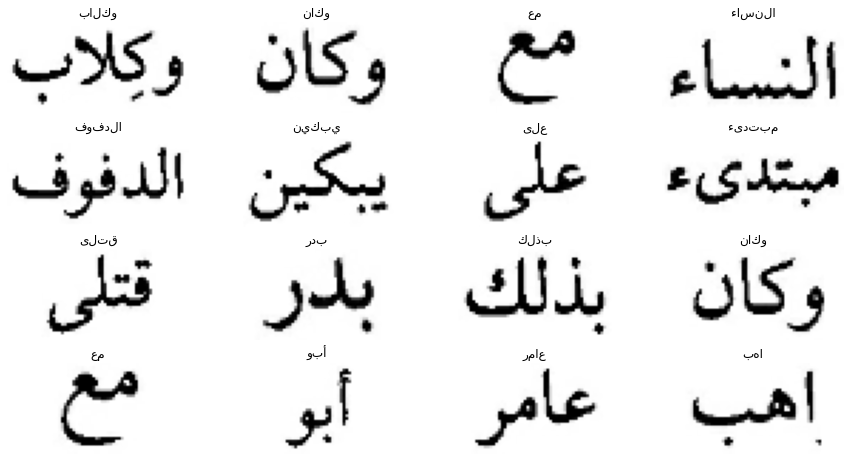

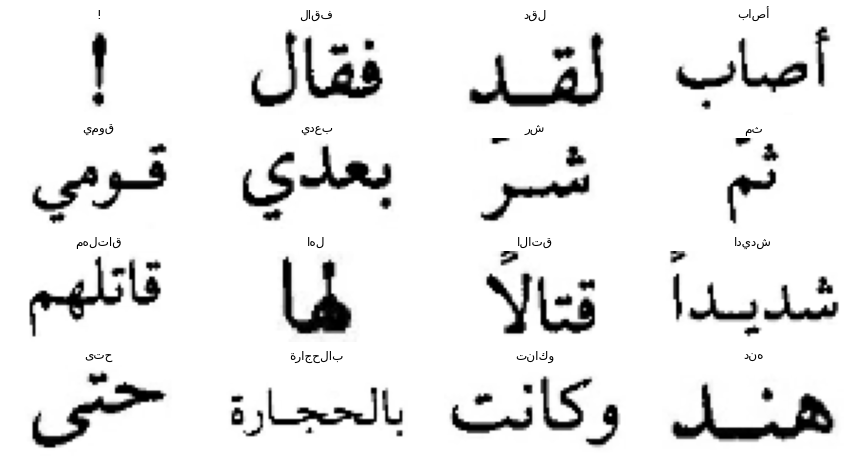

In [20]:
for data in test_ds.take(2):
    images, labels = data["image"], data["label"]

    _, ax = plt.subplots(4, 4, figsize=(15, 8))

    for i in range(16):
        img = images[i]
        img = tf.image.flip_left_right(img)
        img = tf.transpose(img, perm=[1, 0, 2])
        img = (img * 255.0).numpy().clip(0, 255).astype(np.uint8)
        img = img[:, :, 0]

        # Gather indices where label!= padding_token.
        label = labels[i]
        indices = tf.gather(label, tf.where(tf.math.not_equal(label, padding_token)))
        # Convert to string.
        label = tf.strings.reduce_join(num_to_char(indices))
        label = label.numpy().decode("utf-8")

        ax[i // 4, i % 4].imshow(img, cmap="gray")
        ax[i // 4, i % 4].set_title(label[::-1])
        ax[i // 4, i % 4].axis("off")


plt.show()

# **Model Architecture and training**

In [21]:
class CTCLayer(keras.layers.Layer):
    def __init__(self, name=None):
        super().__init__(name=name)
        self.loss_fn = keras.backend.ctc_batch_cost

    def call(self, y_true, y_pred):
        batch_len = tf.cast(tf.shape(y_true)[0], dtype="int64")
        input_length = tf.cast(tf.shape(y_pred)[1], dtype="int64")
        label_length = tf.cast(tf.shape(y_true)[1], dtype="int64")

        input_length = input_length * tf.ones(shape=(batch_len, 1), dtype="int64")
        label_length = label_length * tf.ones(shape=(batch_len, 1), dtype="int64")
        loss = self.loss_fn(y_true, y_pred, input_length, label_length)
        self.add_loss(loss)

        # At test time, just return the computed predictions.
        return y_pred


def build_model():
    # Inputs to the model
    input_img = keras.Input(shape=(image_width, image_height, 1), name="image")
    labels = keras.layers.Input(name="label", shape=(None,))

    # First conv block.
    x = keras.layers.Conv2D(
        32,
        (3, 3),
        activation="relu",
        kernel_initializer="he_normal",
        padding="same",
        name="Conv1",
    )(input_img)
    x = keras.layers.BatchNormalization()(x)
    x = keras.layers.MaxPooling2D((2, 2), name="pool1")(x)

    # Second conv block.
    x = keras.layers.Conv2D(
        64,
        (3, 3),
        activation="relu",
        kernel_initializer="he_normal",
        padding="same",
        name="Conv2",
    )(x)
    x = keras.layers.BatchNormalization()(x)
    x = keras.layers.MaxPooling2D((2, 2), name="pool2")(x)

    # We have used two max pool with pool size and strides 2.
    # Hence, downsampled feature maps are 4x smaller. The number of
    # filters in the last layer is 64. Reshape accordingly before
    # passing the output to the RNN part of the model.
    new_shape = ((image_width // 4), (image_height // 4) * 64)
    x = keras.layers.Reshape(target_shape=new_shape, name="reshape")(x)
    x = keras.layers.Dense(64, activation="relu", name="dense1")(x)
    x = keras.layers.Dropout(0.2)(x)

    # RNNs.
    x = keras.layers.Bidirectional(
        keras.layers.LSTM(128, return_sequences=True, dropout=0.25)
    )(x)
    x = keras.layers.Bidirectional(
        keras.layers.LSTM(64, return_sequences=True, dropout=0.25)
    )(x)

    # +2 is to account for the two special tokens introduced by the CTC loss.
    # The recommendation comes here: https://git.io/J0eXP.
    x = keras.layers.Dense(
        len(char_to_num.get_vocabulary()) + 2, activation="softmax", name="dense2"
    )(x)

    # Add CTC layer for calculating CTC loss at each step.
    output = CTCLayer(name="ctc_loss")(labels, x)

    # Define the model.
    model = keras.models.Model(
        inputs=[input_img, labels], outputs=output, name="Arabic_Text_recognizer"
    )
    # Optimizer.
    lr_schedule = keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate=0.0001,
    decay_steps=10000,
    decay_rate=0.9)
    opt = keras.optimizers.Adam(learning_rate=lr_schedule)

    # Compile the model and return.
    model.compile(optimizer=opt)
    return model

# Get the model.
model = build_model()
model.summary()

Model: "Arabic_Text_recognizer"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 image (InputLayer)             [(None, 64, 32, 1)]  0           []                               
                                                                                                  
 Conv1 (Conv2D)                 (None, 64, 32, 32)   320         ['image[0][0]']                  
                                                                                                  
 batch_normalization (BatchNorm  (None, 64, 32, 32)  128         ['Conv1[0][0]']                  
 alization)                                                                                       
                                                                                                  
 pool1 (MaxPooling2D)           (None, 32, 16, 32)   0           ['batch_norm

In [22]:
validation_images = []
validation_labels = []

for batch in validation_ds:
    validation_images.append(batch["image"])
    validation_labels.append(batch["label"])

In [23]:
def calculate_wer(labels, predictions):
  return wer(labels, predictions)

def calculate_cer(labels, predictions):
  return cer(labels, predictions)

class WERCERCallback(keras.callbacks.Callback):
    def __init__(self, pred_model):
        super().__init__()
        self.prediction_model = pred_model

    def on_epoch_end(self, epoch, logs=None):
        word_error_rate = []
        char_error_rate = []

        for i in range(len(validation_images)):
            labels = validation_labels[i]
            predictions = self.prediction_model.predict(validation_images[i])
            word_error_rate.append(calculate_wer(labels, predictions).numpy())
            char_error_rate.append(calculate_cer(labels, predictions).numpy())

        print(
            f"Mean WER for epoch {epoch + 1}: {np.mean(word_error_rate):.4f}"
        )
        print(
            f"Mean CER for epoch {epoch + 1}: {np.mean(char_error_rate):.4f}"
        )

In [24]:
def calculate_edit_distance(labels, predictions):
    # Get a single batch and convert its labels to sparse tensors.
    saprse_labels = tf.sparse.from_dense(labels)

    # Make predictions and convert them to sparse tensors.
    input_len = np.ones(predictions.shape[0]) * predictions.shape[1]

    predictions_decoded = keras.backend.ctc_decode(
        
        predictions, input_length=input_len, greedy=False, beam_width=100,
    )[0][0][:, :max_len]
    sparse_predictions =tf.sparse.from_dense(predictions_decoded)
    
    # Compute individual edit distances and average them out.
    edit_distances = tf.edit_distance(
        sparse_predictions, saprse_labels, normalize=False
    )
    return tf.reduce_mean(edit_distances)


class EditDistanceCallback(keras.callbacks.Callback):
    def __init__(self, pred_model):
        super().__init__()
        self.prediction_model = pred_model

    def on_epoch_end(self, epoch, logs=None):
        edit_distances = []

        for i in range(len(validation_images)):
            labels = validation_labels[i]
            predictions = self.prediction_model.predict(validation_images[i])
            edit_distances.append(calculate_edit_distance(labels, predictions).numpy())

        print(
            f"Mean edit distance for epoch {epoch + 1}: {np.mean(edit_distances):.4f}"
        )

In [25]:
epochs = 300  # To get good results this should be at least 50.

model = build_model()
prediction_model = keras.models.Model(
    model.get_layer(name="image").input, model.get_layer(name="dense2").output
)
edit_distance_callback = EditDistanceCallback(prediction_model)
WER_CER_callback = WERCERCallback(prediction_model)

stopping=tf.keras.callbacks.EarlyStopping(
    monitor="val_loss",
    min_delta=0,
    patience=3,
    verbose=0,
    mode="auto",
    baseline=None,
    restore_best_weights=False,
)

# Train the model.
history = model.fit(
    train_ds,
    validation_data=validation_ds,
    epochs=epochs,
    callbacks=[edit_distance_callback],
    shuffle=True
    
)

model.save("/content/finalmodel")
#add early stopping mechanism

Streaming output truncated to the last 5000 lines.
Mean edit distance for epoch 62: 8.0903
139/139 [==============================] - 18s 128ms/step - loss: 4.4155 - val_loss: 5.0712
Epoch 63/300
1/1 [==============================] - 0s 34ms/step
Mean edit distance for epoch 63: 8.0946
139/139 [==============================] - 19s 138ms/step - loss: 4.3562 - val_loss: 5.0122
Epoch 64/300
1/1 [==============================] - 0s 40ms/step
Mean edit distance for epoch 64: 8.0503
139/139 [==============================] - 18s 134ms/step - loss: 4.3151 - val_loss: 4.9771
Epoch 65/300
1/1 [==============================] - 0s 34ms/step
Mean edit distance for epoch 65: 8.0208
139/139 [==============================] - 20s 141ms/step - loss: 4.2682 - val_loss: 4.9418
Epoch 66/300
1/1 [==============================] - 0s 23ms/step
Mean edit distance for epoch 66: 8.0399
139/139 [==============================] - 19s 139ms/step - loss: 4.2490 - val_loss: 4.8950
Epoch 67/300
1/1 [===========

In [26]:
model.save("/content/drive/MyDrive/FINAL_MODEL")

In [45]:
prediction_model.save('/content/model.model')

In [42]:
# Evaluate the model on the test data using `evaluate`
print("Evaluate on test data")
results = model.evaluate(test_ds, batch_size=64, callbacks=[edit_distance_callback])
print("test loss", results)

Evaluate on test data
18/18 [==============================] - 1s 72ms/step - loss: 2.2026
test loss 2.2026431560516357


In [43]:
# A utility function to decode the output of the network.
def decode_batch_predictions(pred):
    input_len = np.ones(pred.shape[0]) * pred.shape[1]
    # Use greedy search. For complex tasks, you can use beam search.
    results = keras.backend.ctc_decode(pred, input_length=input_len, greedy=True)[0][0][
        :, :max_len
    ]
    # Iterate over the results and get back the text.
    output_text = []
    for res in results:
        res = tf.gather(res, tf.where(tf.math.not_equal(res, -1)))
        res = tf.strings.reduce_join(num_to_char(res)).numpy().decode("utf-8")
        output_text.append(res)
    print(output_text)
    return output_text

In [29]:
for batch in test_ds.take(1):
    batch_images = batch["image"]
    label_images = batch['label']

    preds = prediction_model.predict(batch_images)
    pred_texts = decode_batch_predictions(preds)   
    print(label_images.shape)

2/2 [==============================] - 0s 9ms/step
['وكاب', 'وكان', 'مع', 'النساء', 'القوف', 'يكين', 'على', 'متء', 'قتلى', 'بدر', 'بذلك', 'وكان', 'مع', 'أبو', 'عامر', 'اهب', 'النصاري', 'وكان', 'في', 'حرح', 'إلى', 'مكة', 'مبدا', 'الله', 'ومعه', 'خحسمون', 'غلاما', 'من', 'وس', 'ذكر', 'وقيل', 'كانوا', 'خسة', 'عشر', 'يعد', 'قريا', 'أنه', 'لو', 'لقي', 'محمدا', 'الأ', 'لم', 'ينخلف', 'عنه', 'من', 'الأ', 'ومس', 'فلما', 'التى', 'الناس', 'بحد', 'سباب', 'كان', 'أبو', 'عامر', 'فقالوا', 'فلا', 'أنم', 'الله', 'بك', 'عينا', 'يا', 'التي', 'فااسق']
(64, 10)


In [30]:
ground_truth = []
predictions = []
#  Let's check results on some test samples.
for batch in test_ds:
    batch_images = batch["image"]
    label_images = batch['label']
    _, ax = plt.subplots(4, 4, figsize=(20, 8))

    preds = prediction_model.predict(batch_images)
    pred_texts = decode_batch_predictions(preds)

    ground_truth.extend(label_images)
    predictions.extend(pred_texts)   

    for i in range(16):
        img = batch_images[i]
        img = tf.image.flip_left_right(img)
        img = tf.transpose(img, perm=[1, 0, 2])
        img = (img * 255.0).numpy().clip(0, 255).astype(np.uint8)
        img = img[:, :, 0]

        title = f"Prediction: {pred_texts[i]}"
        ax[i // 4, i % 4].imshow(img, cmap="gray")
        ax[i // 4, i % 4].set_title(title)
        ax[i // 4, i % 4].axis("off")

plt.show()

Output hidden; open in https://colab.research.google.com to view.

In [31]:
len(test_labels_cleaned)

1105

# **Before Post processing**

In [32]:

sum_wer = 0
sum_cer = 0
sum_edit_distance = 0
delete_costs = np.ones(128, dtype=np.float64)
insert_costs = np.ones(128, dtype=np.float64)
sub_costs = np.ones(128, dtype=np.float64)
for groundtruth, predict in zip(test_labels_cleaned, predictions):
  try:
    word_err = calculate_wer(groundtruth, predict)
    char_err = calculate_cer(groundtruth, predict)
    print('Ground truth: ', groundtruth, ' Prediction: ', predict,
          ' WER: ', word_err, ' CER: ', char_err)
    sum_wer += word_err
    sum_cer += char_err
    # sum_edit_distance += lev(groundtruth, predict, insert_costs=insert_costs)
  except ValueError:
    print('empty string')

print('Mean WER: ', (sum_wer/679)*100)
print('Mean CER: ', (sum_cer/679)*100)
# print('Mean Edit Distance: ', sum_edit_distance/679)
print('Accuracy Word: ', 100-(sum_wer/679)*100)
print('Accuracy Char: ', 100-(sum_cer/679)*100)


Ground truth:  وكلاب  Prediction:  وكاب  WER:  1.0  CER:  0.2
Ground truth:  وكان  Prediction:  وكان  WER:  0.0  CER:  0.0
Ground truth:  مع  Prediction:  مع  WER:  0.0  CER:  0.0
Ground truth:  النساء  Prediction:  النساء  WER:  0.0  CER:  0.0
Ground truth:  الدفوف  Prediction:  القوف  WER:  1.0  CER:  0.3333333333333333
Ground truth:  يبكين  Prediction:  يكين  WER:  1.0  CER:  0.2
Ground truth:  على  Prediction:  على  WER:  0.0  CER:  0.0
Ground truth:  مبتدىء  Prediction:  متء  WER:  1.0  CER:  0.5
Ground truth:  قتلى  Prediction:  قتلى  WER:  0.0  CER:  0.0
Ground truth:  بدر  Prediction:  بدر  WER:  0.0  CER:  0.0
Ground truth:  بذلك  Prediction:  بذلك  WER:  0.0  CER:  0.0
Ground truth:  وكان  Prediction:  وكان  WER:  0.0  CER:  0.0
Ground truth:  مع  Prediction:  مع  WER:  0.0  CER:  0.0
Ground truth:  أبو  Prediction:  أبو  WER:  0.0  CER:  0.0
Ground truth:  عامر  Prediction:  عامر  WER:  0.0  CER:  0.0
Ground truth:  اهب  Prediction:  اهب  WER:  0.0  CER:  0.0
Ground truth:  

In [33]:
# Print the accuracy of the model
print('validation loss:', history.history['val_loss'][-1])

validation loss: 2.4161975383758545


In [34]:
model.save('/content/model.h5')

In [46]:
import cv2 as cv

In [48]:
img1 = cv.imread('/content/السلام.jpg')
img1 = cv.cvtColor(img1 , cv.COLOR_BGR2GRAY)
cv.imwrite('/content/img1.jpg', img1)

True

In [49]:
img1 = preprocess_image('/content/img1.jpg')
img2 = preprocess_image('/content/عليكم.jpg')
img3 = preprocess_image('/content/ورحمة.jpg')
img4 = preprocess_image('/content/الله.jpg')
img5 = preprocess_image('/content/وبركاته.jpg')
img6 = preprocess_image('/content/نمق.jpg')
img7 = preprocess_image('/content/img32.jpg')

In [ ]:
for batch in test_ds.take(1):
    batch_images = batch["image"]
    label_images = batch['label']

    preds = prediction_model.predict(batch_images)
    pred_texts = decode_batch_predictions(preds)   
    print(label_images.shape)

In [54]:
prediction_model.save('/content/drive/MyDrive/prediction_model')
model.save('/content/drive/MyDrive/last_model')

In [55]:
model = tf.keras.models.load_model('/content/model.model')

In [52]:
prediction = model.predict([img1])
pred_text = decode_batch_predictions(prediction) 
print(pred_text)

ValueError: ignored

Text(0, 0.5, 'frequency')

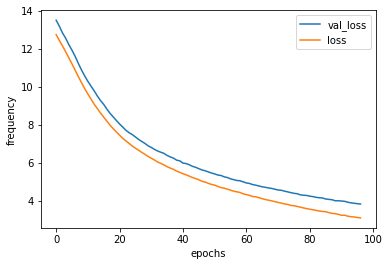

In [ ]:
plt.plot(history.history['val_loss'][2:len(history.history['val_loss'])-1], label= 'val_loss')
plt.plot(history.history['loss'][2:len(history.history['loss'])-1], label= 'loss')
plt.legend(loc= 'upper right')
plt.xlabel('epochs')
plt.ylabel('frequency')

Text(0, 0.5, 'frequency')

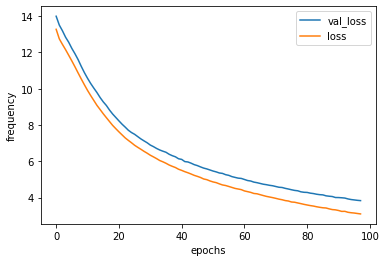

In [ ]:

plt.plot(history.history['val_loss'][1:len(history.history['val_loss'])-1], label= 'val_loss')
plt.plot(history.history['loss'][1:len(history.history['loss'])-1], label= 'loss')
plt.legend(loc= 'upper right')
plt.xlabel('epochs')
plt.ylabel('frequency')

Text(0, 0.5, 'frequency')

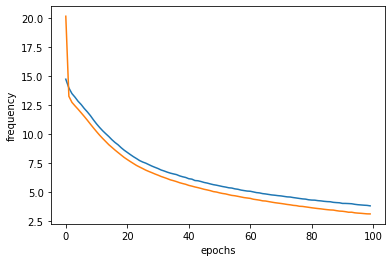

In [ ]:
plt.plot(history.history['val_loss'])
plt.plot(history.history['loss'])
plt.xlabel('epochs')
plt.ylabel('frequency')